import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
with open('dbinfo_cls.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)

dbinfo.keys(), len(dbinfo['train_cls_imgList']), len(dbinfo['test_cls_imgList'])

(dict_keys(['meta', 'train_cls_imgList', 'train_cls_grndMaskList', 'train_cls_predMaskList', 'train_cls_classID', 'test_cls_imgList', 'test_cls_grndMaskList', 'test_cls_predMaskList', 'test_cls_classID']),
 42115,
 4720)

In [36]:
class PollenCls(Dataset):
    def __init__(self, dbinfo, size=[120, 120], set_name='train', maskType='pred'):
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name
        self.imageList = dbinfo[set_name+'_cls_imgList']
        
        if maskType=='pred':
            self.segList = dbinfo[set_name+'_cls_predMaskList']
        else:
            self.segList = dbinfo[set_name+'_cls_grndMaskList']
        
        self.clsIDList = dbinfo[set_name+'_cls_classID']
        self.transform = transform                
        self.size = size
        
        self.TFNormalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        self.current_set_len = len(self.imageList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curImageName = self.imageList[idx]
        curMaskName = self.segList[idx]
        curLabelIndex = self.clsIDList[idx].astype(np.float32)-1
        curLabelIndex = np.array([curLabelIndex]).astype(np.float32)
        
        image = PIL.Image.open(curImageName)
        segMask = PIL.Image.open(curMaskName)
        
        if self.set_name=='train' and np.random.random(1)>0.5:
            image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            segMask = segMask.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            
        image = np.array(image)
        segMask = np.array(segMask).astype(np.float32)
        times = np.random.randint(4)
        image = np.rot90(image, times).copy()
        segMask = np.rot90(segMask, times).copy()
        
        #print('rot90 ', image.max(), image.min())
        
        image = self.TF2tensor(image)
        #print('to tensor ', image.max(), image.min())
        
        image = self.TFNormalize(image)
        #print('normalize ', image.max(), image.min())
        
        segMask = torch.from_numpy(segMask).unsqueeze(0) # self.TF2tensor(mask_overlap)                
        label = torch.from_numpy(curLabelIndex).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        
        image = image.unsqueeze(0)
        segMask = segMask.unsqueeze(0)        
        
        #print(image.shape, segMask.shape)
        image = F.interpolate(image, size=(self.size[0],self.size[1]), mode='bilinear', align_corners=True)
        segMask = F.interpolate(segMask, size=(self.size[0], self.size[1]), mode='nearest')
        image = image.squeeze(0)        
        label = label.squeeze(0)
        return image, segMask, label

In [37]:
batch_size = 16

cls_datasets = {set_name: PollenCls(dbinfo,
                                    size=[128, 128], 
                                    set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(cls_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(cls_datasets['train']), len(cls_datasets['test']))

42115 4720


In [48]:
data_sampler = iter(dataloaders['test'])

In [49]:
data = next(data_sampler)

image, segMask, label = data
#image.shape, label.shape, mask_distanceTransform.shape, mask_overlap.shape, mask_voteX.shape, mask_voteY.shape, mask_peaks.shape, mask_radius.shape

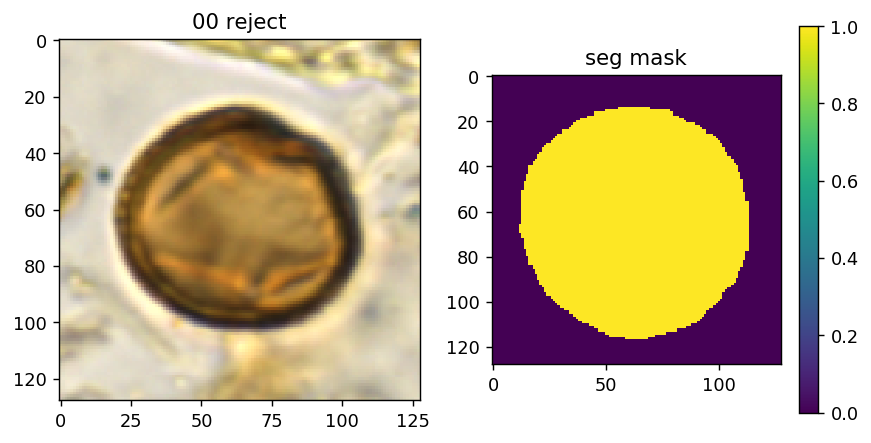

In [52]:
idx = 11
tmplabel = label[idx].squeeze().cpu().detach().numpy()
tmplabel = round(tmplabel.item())
labelName = dbinfo['meta'][tmplabel-1]


numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(8, 4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('{:02d} '.format(tmplabel)+labelName)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = segMask[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')
plt.colorbar()




Leaving Blank
-----